In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy.stats as sps

from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple
from scipy.interpolate import CubicSpline, UnivariateSpline, RectBivariateSpline
from vol import heston

warnings.filterwarnings('ignore')

In [2]:
r = 0.05
initial_price = 100

myheston = heston.Heston(s=initial_price, v=1, kappa=1, theta=0.4, sigma=0.4, rho=0.5, r=r)

T_grid = np.linspace(0.2, 1, 7)
K_grid = np.linspace(60, 140, 10)

call_prices = myheston.call_price(T_grid.reshape(-1, 1), K_grid)
implied_volatilities = myheston.iv(T_grid.reshape(-1, 1), K_grid)

In [3]:
class LocalVolatility:
    
    def __init__(self, r, initial_price):
        self.r = r
        self.initial_price = initial_price
    
    def set_new_coordinates(self, iv, K_grid, T_grid):

        self.y = np.log(np.repeat(K_grid.reshape(1, -1), len(T_grid), axis=0)) - np.log(self.initial_price)
        self.w = np.repeat(T_grid.reshape(1, -1), len(K_grid), axis=0).T * np.square(iv)
        
    def get_new_coordinates(self):
        return self.y, self.w

    def set_extended_grid(self, iv, y, w, N = 500, gamma = 1):

        ind = np.argmin(np.abs(np.log(y)))
        ATM_iv = iv[:, ind] # BS implied vol of ATM market options
        D = gamma * np.mean(ATM_iv) * np.sqrt(np.max(w))

        w_values = np.linspace(np.min(w), np.max(w), N + 1)
        y_values = np.linspace(-D, D, N + 1)

        self.y_extended, self.w_extended = np.meshgrid(y_values, w_values)
        
    def get_extended_grid(self):
        return self.y_extended, self.w_extended
    
    def make_implied_volatility_surface(self, iv, K_grid, T_grid, y, w, y_extended, w_extended):
        
        Theta = np.zeros_like(y_extended)
        dTheta_dy = np.zeros_like(y_extended)
        d2Theta_dy = np.zeros_like(y_extended)
        dTheta_dw = np.zeros_like(y_extended)

        w_k_extended = np.zeros((len(T_grid), y_extended.shape[1]))
        tmp = np.zeros((len(T_grid), y_extended.shape[1]))
        tmp1 = np.zeros((len(T_grid), y_extended.shape[1]))
        tmp2 = np.zeros((len(T_grid), y_extended.shape[1]))

        # iterate over time
        for i in range(len(T_grid)):
            spline = CubicSpline(y[i], iv[i], bc_type='natural')

            tmp[i] = spline(y_extended[i])
            tmp1[i] = spline.derivative(nu=1)(y_extended[i])
            tmp2[i] = spline.derivative(nu=2)(y_extended[i])

        # extend w over y
        for i in range(len(T_grid)):
            spline = CubicSpline(y[i], w[i], bc_type='natural')
            w_k_extended[i] = spline(y_extended[i])

        # iterate over strikes
        for j in range(y_extended.shape[1]):
            spline = UnivariateSpline(w_k_extended[:, j], tmp1[:, j], k=1)
            dTheta_dy[:, j] = spline(w_extended[:, j])

        for j in range(y_extended.shape[1]):
            spline = UnivariateSpline(w_k_extended[:, j], tmp2[:, j], k=1)
            d2Theta_dy[:, j] = spline(w_extended[:, j])

        for j in range(y_extended.shape[1]):
            spline = UnivariateSpline(w_k_extended[:, j], tmp[:, j], k=1)
            Theta[:, j] = spline(w_extended[:, j])
            dTheta_dw = spline.derivative(n=1)(w_extended[:, j])

        self.Theta = Theta
            
        return Theta, dTheta_dy, d2Theta_dy, dTheta_dw
    
    def get_extended_iv(self):
        return self.Theta
    
    def calculate_local_volatility(self, y_extended, w_extended, Theta, dTheta_dy, d2Theta_dy, dTheta_dw):

        d1_sqrt_t = (-y_extended + self.r * w_extended / np.square(Theta) + 0.5 * w_extended) / Theta
        num = (Theta ** 3) / (Theta - 2 * w_extended * dTheta_dw) + 2 * self.r * w_extended * dTheta_dy/Theta
        denum = ((1 + d1_sqrt_t * dTheta_dy) ** 2) +\
            w_extended / Theta * (d2Theta_dy - dTheta_dy - d1_sqrt_t * np.square(dTheta_dy))

        self.local_volatility = np.sqrt(np.maximum(num / denum, np.zeros_like(Theta)))
        
    def get_local_volatility(self):
        return self.local_volatility
    
    def calibrate(self, iv, K_grid, T_grid, N = 500, gamma = 1):
    
        self.set_new_coordinates(iv, K_grid, T_grid)

        self.set_extended_grid(iv, *self.get_new_coordinates(), N, gamma)

        Theta, dTheta_dy, d2Theta_dy, dTheta_dw = self.make_implied_volatility_surface(
            iv, K_grid, T_grid, *self.get_new_coordinates(), *self.get_extended_grid()
        )

        self.calculate_local_volatility(
            *self.get_extended_grid(), Theta, dTheta_dy, d2Theta_dy, dTheta_dw
        )

In [4]:
lv = LocalVolatility(r, initial_price)

In [5]:
N = 500
gamma = 1

# shape(implied volatilities) = shape(K_grid) = shape(T_grid)
lv.calibrate(implied_volatilities, K_grid, T_grid, N, gamma)

In [6]:
y_extended, w_extended, loc_vol, theta = *lv.get_extended_grid(), lv.get_local_volatility(), lv.get_extended_iv()

In [7]:
K_extended = np.exp(y_extended) * initial_price
T_extended = w_extended / theta / theta

# Plot initital iv

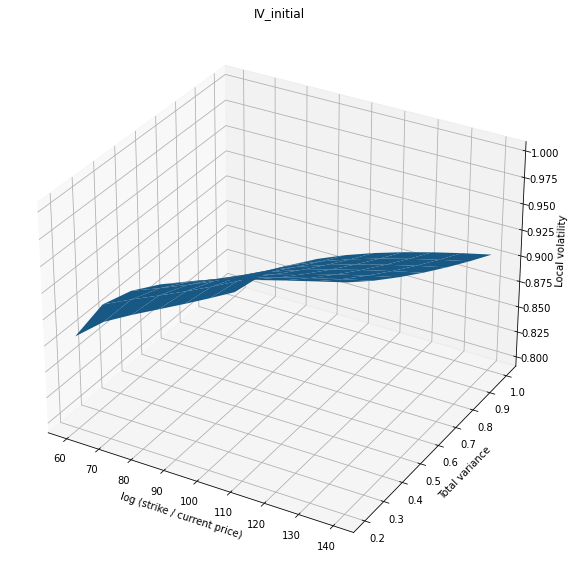

In [8]:
fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(*np.meshgrid(K_grid, T_grid), implied_volatilities)
ax2.set_title('IV_initial')
ax2.set_xlabel('log (strike / current price)')
ax2.set_ylabel('Total variance')
ax2.set_zlabel('Local volatility')
# ax2.set_zlim(0.0, 0.5)

plt.show()

# Plot extended iv 

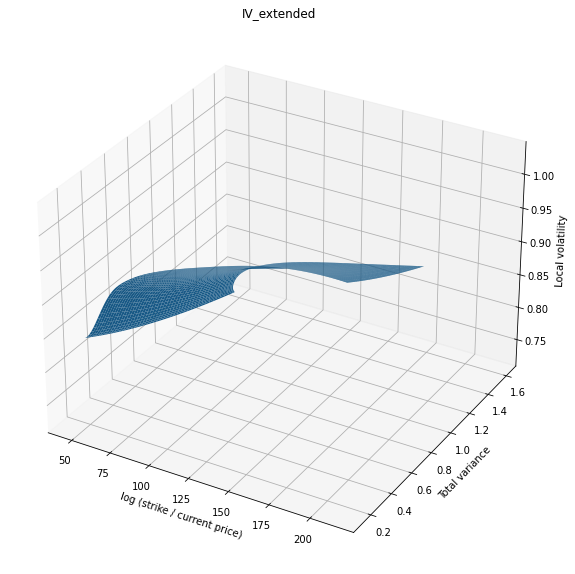

In [10]:
fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(K_extended, T_extended, theta)
ax2.set_title('IV_extended')
ax2.set_xlabel('log (strike / current price)')
ax2.set_ylabel('Total variance')
ax2.set_zlabel('Local volatility')
# ax2.set_zlim(0.0, 0.5)

plt.show()

# Plot local vol obtained

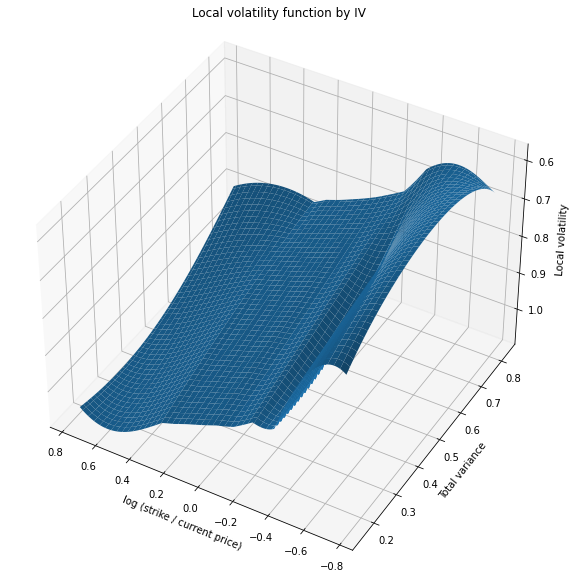

In [11]:
fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(y_extended, w_extended, loc_vol)
ax2.set_title('Local volatility function by IV')
ax2.set_xlabel('log (strike / current price)')
ax2.set_ylabel('Total variance')
ax2.set_zlabel('Local volatility')
# ax2.set_zlim(0.0, 0.5)
ax2.view_init(-140, 60)

plt.show()

# Solve PDE by implicit scheme

# $V_t + (r - q - \frac{1}{2} \sigma^2)V_x + \frac{1}{2} \sigma^2 V_{xx} = rV$, $\;\;\;\nu := r - q - \frac{1}{2} \sigma^2$

$\frac{V^{i}_j - V^{i - 1}_j}{\tau} + \nu^{i - 1}_j \frac{V^{i - 1}_{j + 1} - V^{i - 1}_{j - 1}}{2 h} + \frac{1}{2} (\sigma^2)^{i - 1}_j \frac{V^{i - 1}_{j - 1} - 2 V^{i - 1}_j + V^{i - 1}_{j + 1}}{h^2} = r V^{i - 1}_j$

$\left(-\frac{\nu^{i - 1}_j}{2 h} + \frac{1}{2 h^2} (\sigma^2)^{i - 1}_j \right)V^{i - 1}_{j - 1} + \left(-\frac{1}{\tau} - \frac{1}{h^2} (\sigma^2)^{i - 1}_j - r\right) V^{i - 1}_j + \left(\frac{\nu^{i - 1}_j}{2 h} + \frac{1}{2 h^2} (\sigma^2)^{i - 1}_j \right) V^{i - 1}_{j + 1} = -\frac{1}{\tau} V^i_j$

$\left(\frac{\tau \nu^{i - 1}_j}{2 h} - \frac{\tau}{2 h^2} (\sigma^2)^{i - 1}_j \right)V^{i - 1}_{j - 1} + \left(1 + \frac{\tau}{h^2} (\sigma^2)^{i - 1}_j + r\tau \right) V^{i - 1}_j + \left(-\frac{\tau \nu^{i - 1}_j}{2 h} - \frac{\tau}{2 h^2} (\sigma^2)^{i - 1}_j \right) V^{i - 1}_{j + 1} = V^i_j$

$V^i_0 - V^i_1 = 0, \;\;\; V^i_{M} - V^i_{M - 1} = S[M] - S[M - 1], \;\;\; V^N_j = (S[j] - K)^+$

In [12]:
def progonka_final(c, d, e, b):
    """
    Solves the following system of linear equations (w.r.t. x = (x[0], x[1], ..., x[n - 1])):

    d[0] * x[0] + e[0] * x[1] = b[0],
    c[0] * x[0] + d[1] * x[1] + e[1] * x[2] = b[1],
    ...
    c[i - 1] * x[i - 1] + d[i] * x[i] + e[i] * x[i + 1] = b[i],
    ...
    c[n - 3] * x[n - 3] + d[n - 2] * x[n - 2] + e[n - 2] * x[n - 1] = b[n - 2],
    c[n - 2] * x[n - 2] + d[n - 1] * x[n - 1] = b[n - 1]

    """
    n = len(b)
    alpha, beta = np.zeros(n - 1), np.zeros(n - 1)
    alpha[0], beta[0] = -e[0] / d[0], b[0] / d[0]
    
    for i in range(1, n - 1):
        alpha[i] = -e[i] / (d[i] + c[i - 1] * alpha[i - 1])
        beta[i] = (-c[i - 1] * beta[i - 1] + b[i]) / (d[i] + c[i - 1] * alpha[i - 1])
        
    ans = np.zeros(n)
    ans[-1] = (-c[-1] * beta[-1] + b[-1]) / (d[-1] + c[-1] * alpha[-1])
    
    for i in range(n - 2, -1, -1):
        ans[i] = ans[i + 1] * alpha[i] + beta[i]
        
    return ans

In [13]:
def get_call_option_price_implicit_scheme(K, loc_vol, K_extended, T_extended, N = 500):
    """
    Args:
        K: strike, scalar
        loc_vol: local volatility, matrix
        K_extended, T_extended: coordinates, two matrices
    """
    
    S = K_extended[0]
    tau, h = T_extended.max() / N, np.log(K_extended[0, 1] / K_extended[0, 0])

    def c(nu, tau, h, sigma):
        return nu / 2 / h - np.square(sigma) / 2 / h / h

    def d(tau, h, sigma, r = 0):
        return 1 / tau + 1 / h / h * np.square(sigma) + r

    def e(nu, tau, h, sigma):
        return -nu / 2 / h - np.square(sigma) / 2 / h / h

    V = np.zeros_like(loc_vol)

    V[-1] = np.maximum(S - K, np.zeros_like(S - K))

    for i in range(N, 0, -1):
        nu = r - 0.5 * (loc_vol[i - 1, 1:-1] ** 2)
        c_current = np.array(list(c(nu, tau, h, loc_vol[i - 1, 1:-1])) + [-1])
        d_current = np.array([1] + list(d(tau, h, loc_vol[i - 1, 1:-1], r)) + [1])
        e_current = np.array([-1] + list(e(nu, tau, h, loc_vol[i - 1, 1:-1])))

        b = np.array([0] + list(V[i, 1:-1] / tau) + [S[-1] - S[-2]])
        V[i - 1] = progonka_final(c_current, d_current, e_current, b)
        
    return V

# Plot obtained call prices

In [14]:
K = 120

V = get_call_option_price_implicit_scheme(K, loc_vol, K_extended, T_extended)

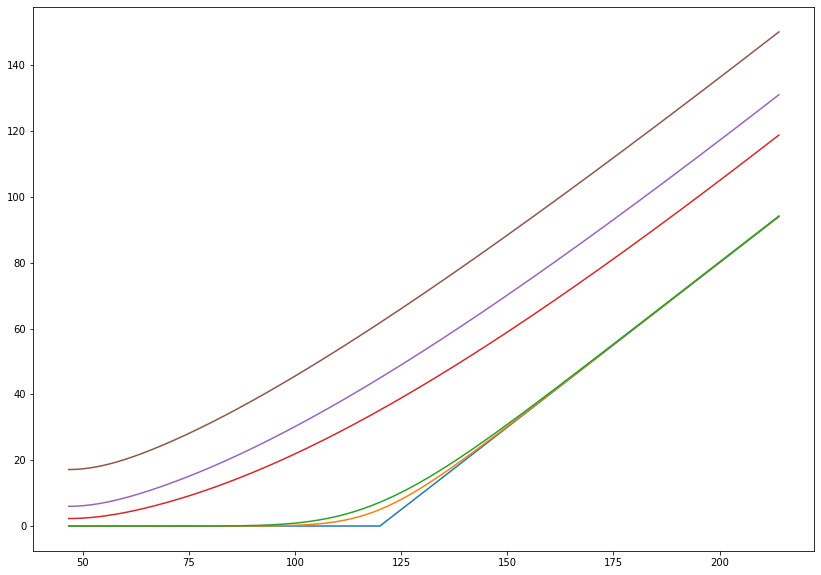

In [23]:
plt.figure(figsize=(14, 10))

plt.plot(K_extended[0],V[500])
plt.plot(K_extended[0],V[495])
plt.plot(K_extended[0],V[490])
plt.plot(K_extended[0],V[300])
plt.plot(K_extended[0],V[200])
plt.plot(K_extended[0],V[0])

plt.show()

# Lets hedge!

In [24]:
def get_trajectory(S, T_extended):
    """
    Args:
        S: extended price grid (== strike grid), vector
    """
    iterations = 0
    MAX_ITERATIONS = 100
    
    while iterations < MAX_ITERATIONS:
        stock_prices = myheston.simulate_euler(T_extended.max(), len(T_extended), 1)
        if stock_prices.min() >= S[0] and stock_prices.max() <= S[-1]:
            return stock_prices.flatten()
        iterations += 1
        
    print('cannot simulate')


In [25]:
def delta_function(stock_price, K, S, V, iv, t_max, t, method, r):
    """
    IMPORTANT: V is a vector here
    """
    if method != 'BS':
        spline = CubicSpline(S, V, bc_type='natural')
        return spline.derivative(nu=1)(stock_price)
    
    spline_theta = CubicSpline(S, iv, bc_type='natural')
    volatility = spline_theta(stock_price)
    d1_num = np.log(stock_price / K) + (volatility * volatility / 2 + r) * (t_max - t)
    d1_denum = volatility * np.sqrt(t_max - t)
    return sps.norm.cdf(d1_num / d1_denum)
    
    
def call_price_function(stock_price, S, V):
    spline = CubicSpline(S, V, bc_type='natural')
    return spline(stock_price)

def hedge(K, S, V, iv, stock_prices, call_price_function, delta_function, times, method, r = 0.05):
    """
    Args:
        K: strike, scalar
        S: extended strike grid, vector
        V: call prices, matrix
        iv: implied volatility on the extended grid, matrix
        stock_prices: trajectory, vector indexed by time
        call_price_function: pricing function for a call option
        delta_function: function to obtain delta
        times: extended time grid, vector
        method: 'BS' -- Black-Scholes, local volatility otherwise
        r: interest rate
    Returns:
        pnl: pnl trajectory, vector
        call prices: theoretical call price trajectory, vector
    """
    money_account = call_price_function(stock_prices[0], S, V[0])
    delta = 0
    pnl = []
    V_trajectory = []
    
    for i in range(len(V) - 1):
        new_delta = delta_function(stock_prices[i], K, S, V[i], iv[i], times[-1], times[i], method, r)
        money_account -= (new_delta - delta) * stock_prices[i]
        money_account *= np.exp(r * (times[i + 1] - times[i]))
        delta = new_delta
        
        pnl.append(money_account + delta * stock_prices[i])
        V_trajectory.append(call_price_function(stock_prices[i], S, V[i]))
        
    pnl, V_trajectory = np.array(pnl), np.array(V_trajectory)
    
    return pnl, V_trajectory

# Hedge BS

In [26]:
stock_prices = get_trajectory(K_extended[0], T_extended)

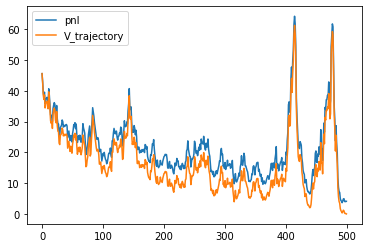

In [29]:
pnl, V_trajectory = hedge(
    K, K_extended[0], V, lv.get_extended_iv(),
    stock_prices, call_price_function, delta_function,
    T_extended[:, 0], 'BS', r
)

plt.plot(pnl, label='pnl')
plt.plot(V_trajectory, label='V_trajectory')
plt.legend()
plt.show()

# Hedge loc vol 

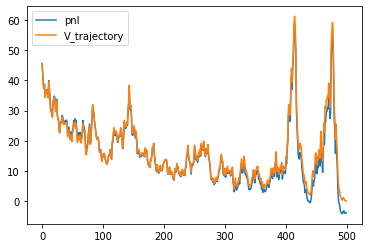

In [30]:
pnl, V_trajectory = hedge(
    K, K_extended[0], V, lv.get_extended_iv(),
    stock_prices, call_price_function, delta_function,
    T_extended[:, 0], 'LocVol', r
)

plt.plot(pnl, label='pnl')
plt.plot(V_trajectory, label='V_trajectory')
plt.legend()
plt.show()

# We see that Loc Vol is much better - that is, less error in the end

# Now lets check mean and std of the error in the end

In [31]:
from tqdm import tqdm

def get_mean_std_of_hedging(method_type, K, Nsteps, doPlot=True):
    mas_errors = []
    for i in range(Nsteps):
        stock_prices = get_trajectory(K_extended[0], T_extended)
        pnl, V_trajectory = hedge(
            K, K_extended[0], V, lv.get_extended_iv(),
            stock_prices, call_price_function, delta_function,
            T_extended[:, 0], method_type, r
        )
        mas_errors.append(pnl[-1] - V_trajectory[-1])

    m, s = np.mean(mas_errors), np.std(mas_errors)

    if doPlot:
        print("Mean_error=", m)
        print("Std error=", s)
        plt.hist(mas_errors, density='True',bins=100)
        plt.show()
    
    return m, s

Mean_error= 14.145541991679739
Std error= 7.313487603699252


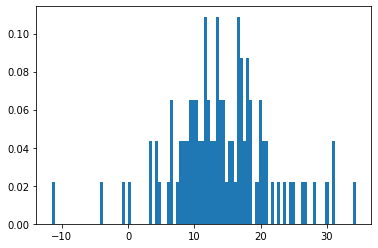

(14.145541991679739, 7.313487603699252)

In [32]:
#BS out-of-the-money
#S0=100 - см. heston initialization
get_mean_std_of_hedging('BS', K=120, Nsteps=100)

Mean_error= 6.515083613300391
Std error= 7.681978386875293


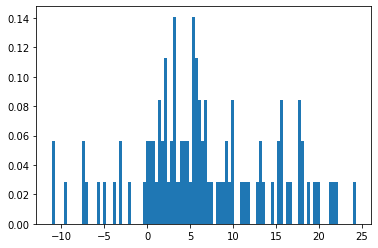

(6.515083613300391, 7.681978386875293)

In [33]:
#loc vol out-of-the-money
#S0=100 - см. heston initialization
get_mean_std_of_hedging('LocVol', K=120, Nsteps=100)

Mean_error= 12.407916113709037
Std error= 11.114356930782952


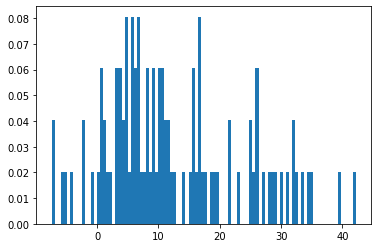

(12.407916113709037, 11.114356930782952)

In [34]:
#BS ATM
#S0=100 - см. heston initialization
get_mean_std_of_hedging('BS', K=100, Nsteps=100)

Mean_error= 5.579010280904364
Std error= 7.828872327736033


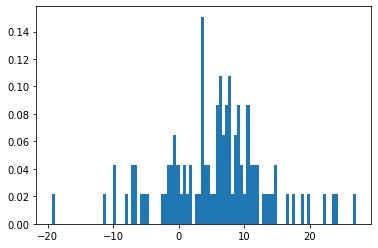

(5.579010280904364, 7.828872327736033)

In [35]:
#loc vol ATM
#S0=100 - см. heston initialization
get_mean_std_of_hedging('LocVol', K=120, Nsteps=100)

Mean_error= 14.572991075330897
Std error= 15.903713736008891


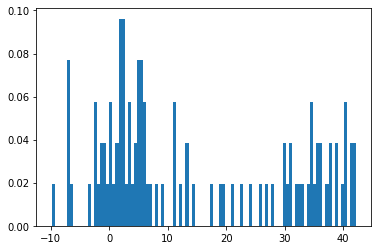

(14.572991075330897, 15.903713736008891)

In [36]:
#BS ITM
#S0=100 - см. heston initialization
get_mean_std_of_hedging('BS', K=80, Nsteps=100)

Mean_error= 6.017033080415496
Std error= 7.3401665275430945


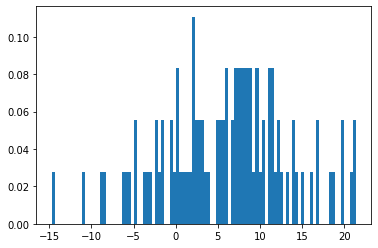

(6.017033080415496, 7.3401665275430945)

In [37]:
#loc vol ITM
#S0=100 - см. heston initialization
get_mean_std_of_hedging('LocVol', K=80, Nsteps=100)

# Видим, что и OTM, и ATM, и ITM опционы лучше хеджируются в модели loc_vol!

100%|██████████| 20/20 [31:28<00:00, 94.41s/it]


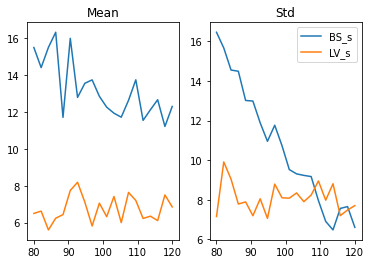

In [96]:
mas_bs_m = []
mas_bs_s = []
mas_lv_m = []
mas_lv_s = []
ks = np.linspace(80, 120, 20)

for k in tqdm(ks):
    bs_m, bs_s = get_mean_std_of_hedging('BS', K=k, Nsteps=100, doPlot=False)
    mas_bs_m.append(bs_m)
    mas_bs_s.append(bs_s)
    lv_m, lv_s = get_mean_std_of_hedging('LocVol', K=k, Nsteps=100, doPlot=False)
    mas_lv_m.append(lv_m)
    mas_lv_s.append(lv_s)


fig, ax = plt.subplots(1,2)
ax[0].plot(ks, mas_bs_m, label='BS_m')
ax[0].plot(ks, mas_lv_m, label='LV_m')
ax[0].set_title('Mean')
ax[1].plot(ks, mas_bs_s, label='BS_s')
ax[1].plot(ks, mas_lv_s, label='LV_s')
ax[1].set_title('Std')
plt.legend()
plt.show()

# Видим, что модель локальной волатильности хеджирует лучше, чем модель Блэка-Шоулза; причем сама по себе модель локальной волатильности почти одинаково хорошо хеджирует ITM, ATM, OTM опционы

100%|██████████| 20/20 [33:09<00:00, 99.48s/it] 


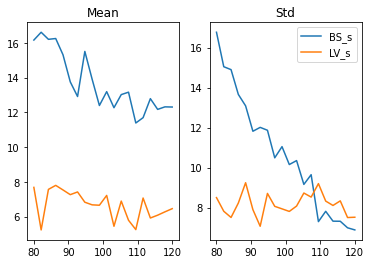

In [38]:
mas_bs_m = []
mas_bs_s = []
mas_lv_m = []
mas_lv_s = []
ks = np.linspace(80, 120, 20)

for k in tqdm(ks):
    bs_m, bs_s = get_mean_std_of_hedging('BS', K=k, Nsteps=100, doPlot=False)
    mas_bs_m.append(bs_m)
    mas_bs_s.append(bs_s)
    lv_m, lv_s = get_mean_std_of_hedging('LocVol', K=k, Nsteps=100, doPlot=False)
    mas_lv_m.append(lv_m)
    mas_lv_s.append(lv_s)


fig, ax = plt.subplots(1,2)
ax[0].plot(ks, mas_bs_m, label='BS_m')
ax[0].plot(ks, mas_lv_m, label='LV_m')
ax[0].set_title('Mean')
ax[1].plot(ks, mas_bs_s, label='BS_s')
ax[1].plot(ks, mas_lv_s, label='LV_s')
ax[1].set_title('Std')
plt.legend()
plt.show()

In [39]:
V.shape

(501, 501)

In [40]:
call_prices.shape

(7, 10)